**Model traning**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
from google.colab import drive
from scipy.stats import randint

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Car_Price_Predication/data.csv')

# Preprocess the dataset
def preprocess_data(df):
    # Handle missing values and normalize string columns
    for col in ['Model', 'Condition', 'Fuel_Type', 'Transmission', 'Location']:
        df[col] = df[col].fillna('unknown').astype(str).str.strip().str.lower()

    # Drop unnecessary columns
    df = df.drop(['Date'], axis=1, errors='ignore')

    # Encode categorical columns
    label_encoders = {}
    for col in ['Model', 'Condition', 'Fuel_Type', 'Transmission', 'Location']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    return df, label_encoders

# Preprocess the data
processed_data, label_encoders = preprocess_data(data)

# Split the dataset
X = processed_data.drop('Price', axis=1)
y = processed_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reduced hyperparameter search space for faster training
param_dist = {
    'n_estimators': randint(50, 200),  # Reduce the range for quicker results
    'max_depth': [10, 20, None],  # Keep the max depth shallow for faster training
    'min_samples_split': [2, 5],  # Reduced range
    'min_samples_leaf': [1, 2],  # Narrowed range
    'max_features': ['sqrt', 'log2'],  # Updated 'max_features' to correct values
}

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)  # Use all cores during training

# Set up RandomizedSearchCV for faster hyperparameter search
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist,
                                   n_iter=20,  # Reduced number of iterations
                                   cv=3,  # Reduced cross-validation folds for faster training
                                   scoring='r2', n_jobs=-1, verbose=1, random_state=42)

# Fit the model
print("Training in progress...")
random_search.fit(X_train, y_train)

# Get the best model
best_rf_model = random_search.best_estimator_

# Evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    print("\n--- Model Performance ---")
    # Training data
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    print(f"Training Data: MAE = {train_mae:.2f}, R² = {train_r2:.2f}")

    # Testing data
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f"Testing Data: MAE = {test_mae:.2f}, R² = {test_r2:.2f}")

# Call the evaluation function
evaluate_model(best_rf_model, X_train, X_test, y_train, y_test)

# Save the model and encoders to Google Drive
model_path = '/content/drive/MyDrive/Car_Price_Predication/rf_model.pkl'
encoder_path = '/content/drive/MyDrive/Car_Price_Predication/label_encoders.pkl'

with open(model_path, 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)
with open(encoder_path, 'wb') as encoder_file:
    pickle.dump(label_encoders, encoder_file)

print(f"Model and encoders saved successfully to {model_path} and {encoder_path}!")


Mounted at /content/drive
Training in progress...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



--- Model Performance ---
Training Data: MAE = 1631599.00, R² = 0.47
Testing Data: MAE = 1519700.77, R² = 0.57
Model and encoders saved successfully to /content/drive/MyDrive/Car_Price_Predication/rf_model.pkl and /content/drive/MyDrive/Car_Price_Predication/label_encoders.pkl!


Mounted at /content/drive

  Vehicle Price Prediction Tool

Select a vehicle model:
1. Alto
2. Aqua
3. Premio
4. Swfit
5. Vezel
Enter your choice: 3
Select vehicle condition: (Auto-selected: Used)
Select fuel type: (Auto-selected: Petrol)
Select transmission type: (Auto-selected: Auto)

Select location:
1. Central
2. Eastern
3. North central
4. North western
5. Sabaragamuwa
6. Southern
7. Western
Enter your choice: 7
Enter manufacture year (2013-2020): 2013
Enter mileage (23500-172000 KM): 100000
Enter the number of previous owners: 1

Predicted Price: ₨ 12.61 Million

Visualizing price trends...



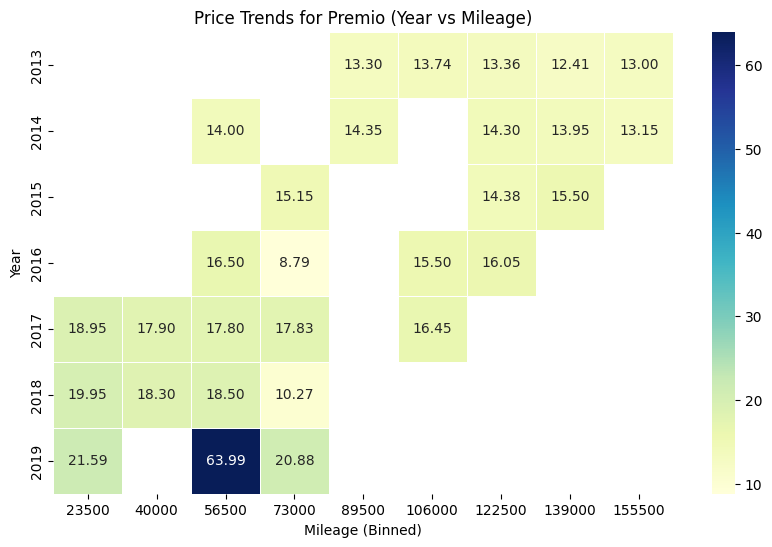

In [ ]:
import pandas as pd
import pickle
from datetime import datetime
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the saved model and encoders from Google Drive
with open('/content/drive/MyDrive/Car_Price_Predication/rf_model.pkl', 'rb') as model_file:
    rf_model = pickle.load(model_file)

with open('/content/drive/MyDrive/Car_Price_Predication/label_encoders.pkl', 'rb') as encoder_file:
    label_encoders = pickle.load(encoder_file)

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Car_Price_Predication/data.csv')

# Extract valid options
def get_valid_options(df):
    options = {
        'Model': sorted(df['Model'].str.lower().unique()),
        'Condition': sorted(df['Condition'].str.lower().unique()),
        'Fuel_Type': sorted(df['Fuel_Type'].str.lower().unique()),
        'Transmission': sorted(df['Transmission'].str.lower().unique()),
        'Location': sorted(df['Location'].str.lower().unique()),
        'Year_Range': (int(df['Year'].min()), int(df['Year'].max())),
        'Mileage_Range': (int(df['Mileage'].min()), int(df['Mileage'].max())),
    }
    return options

valid_options = get_valid_options(data)

# Utility functions
def get_numbered_input(prompt, options):
    """Handles numbered input with auto-selection for single options."""
    if len(options) == 1:
        print(f"{prompt} (Auto-selected: {options[0].capitalize()})")
        return options[0]
    print(f"\n{prompt}")
    for i, option in enumerate(options, 1):
        print(f"{i}. {option.capitalize()}")
    while True:
        try:
            choice = int(input("Enter your choice: ").strip())
            if 1 <= choice <= len(options):
                return options[choice - 1]
            else:
                print(f"Please select a number between 1 and {len(options)}.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

def loading_animation(message="Processing"):
    for _ in range(3):
        for char in ['|', '/', '-', '\\']:
            print(f"{message} {char}", end='\r', flush=True)
            time.sleep(0.2)
    print(" " * len(message), end='\r')

# Main prediction function
def predict_vehicle_price():
    print("\n" + "=" * 40)
    print("  Vehicle Price Prediction Tool")
    print("=" * 40)

    # Select a vehicle model
    model_choice = get_numbered_input("Select a vehicle model:", valid_options['Model'])
    model_data = data[data['Model'].str.lower() == model_choice.lower()]

    # Fetch dynamic conditions for the model
    condition_choices = sorted(model_data['Condition'].str.lower().unique())
    condition_choice = get_numbered_input("Select vehicle condition:", condition_choices)

    # Select additional options
    fuel_type_choice = get_numbered_input("Select fuel type:", sorted(model_data['Fuel_Type'].str.lower().unique()))
    transmission_choice = get_numbered_input("Select transmission type:", sorted(model_data['Transmission'].str.lower().unique()))
    location_choice = get_numbered_input("Select location:", sorted(model_data['Location'].str.lower().unique()))

    # Enter year and mileage
    year_min, year_max = model_data['Year'].min(), model_data['Year'].max()
    while True:
        try:
            year_choice = int(input(f"Enter manufacture year ({year_min}-{year_max}): ").strip())
            if year_choice < year_min or year_choice > year_max:
                print(f"Year out of range. Using nearest value: {year_min if year_choice < year_min else year_max}")
                year_choice = year_min if year_choice < year_min else year_max
            break
        except ValueError:
            print("Invalid input. Please enter a valid year.")

    mileage_min, mileage_max = model_data['Mileage'].min(), model_data['Mileage'].max()
    while True:
        try:
            mileage = int(input(f"Enter mileage ({mileage_min}-{mileage_max} KM): ").strip())
            if mileage < mileage_min or mileage > mileage_max:
                print(f"Mileage out of range. Using nearest value: {mileage_min if mileage < mileage_min else mileage_max}")
                mileage = mileage_min if mileage < mileage_min else mileage_max
            break
        except ValueError:
            print("Invalid input. Please enter a valid mileage.")

    # Enter number of previous owners (only for used vehicles)
    previous_owners = 0
    if condition_choice == 'used':
        while True:
            try:
                previous_owners = int(input("Enter the number of previous owners: ").strip())
                if previous_owners < 0:
                    print("Number of previous owners cannot be negative.")
                else:
                    break
            except ValueError:
                print("Invalid input. Please enter a valid number.")

    # Prepare features for prediction
    input_features = pd.DataFrame([{
        'Model': label_encoders['Model'].transform([model_choice])[0],
        'Year': year_choice,
        'Mileage': mileage,
        'Condition': label_encoders['Condition'].transform([condition_choice])[0],
        'Fuel_Type': label_encoders['Fuel_Type'].transform([fuel_type_choice])[0],
        'Transmission': label_encoders['Transmission'].transform([transmission_choice])[0],
        'Location': label_encoders['Location'].transform([location_choice])[0],
        'Owner': previous_owners
    }])

    # Predict the price
    try:
        predicted_price = rf_model.predict(input_features)[0]
        print(f"\nPredicted Price: ₨ {predicted_price / 1_000_000:.2f} Million")
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # Create mileage bins
    mileage_bins = np.linspace(mileage_min, mileage_max, 10).astype(int)
    model_data = model_data.copy()  # Avoid SettingWithCopyWarning
    model_data.loc[:, 'Mileage_Bin'] = pd.cut(
        model_data['Mileage'], bins=mileage_bins, labels=mileage_bins[:-1]
    )

    # Generate price table
    price_table = pd.pivot_table(
        model_data,
        values='Price',
        index='Year',
        columns='Mileage_Bin',
        aggfunc='mean',
        observed=False  # Explicitly set observed to avoid the FutureWarning
    )

    # Convert prices to millions for display
    price_table = price_table / 1_000_000  # Convert to millions for clarity

    # Plot heatmap
    print("\nVisualizing price trends...\n")
    plt.figure(figsize=(10, 6))
    sns.heatmap(price_table, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)
    plt.title(f"Price Trends for {model_choice.capitalize()} (Year vs Mileage)")
    plt.xlabel("Mileage (Binned)")
    plt.ylabel("Year")
    plt.show()


# Run the function
predict_vehicle_price()
